<a href="https://colab.research.google.com/github/Jaesu26/dacon-3d-mnist-image-classification/blob/main/2022-09-12-%EC%88%AB%EC%9E%903D%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98-%EB%94%A5%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 숫자 3D 이미지 분류 AI 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import h5py
import cv2
import os
import gc

from typing import Callable, Dict, Sequence, List, Optional, Tuple, Union
from tqdm.auto import tqdm
from glob import glob

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/drive')  ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [3]:
%cd  '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data'

/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data


In [4]:
# !unzip -qq '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data/open.zip'

In [5]:
%cd  '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류'

/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류


- 데이터 불러오기

In [6]:
label_df = pd.read_csv('./Data/train.csv')
# all_points = h5py.File('./Data/train.h5', 'r')

In [7]:
test_df = pd.read_csv('./Data/sample_submission.csv')
# test_points = h5py.File('./Data/test.h5', 'r')

In [8]:
target = label_df['label'].values

- 하이퍼파라미터

In [9]:
MODEL_NAME = 'efficientnet_b1'
MODEL_DEFAULT_WEIGHT_PATH = f'{MODEL_NAME}_default_weight.pt' 
SAVE_PATH = './weight4'
NUM_CLASSES = 10
NUM_FOLDS = 5
NUM_EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
LABEL_SMOOTHING = 0.05  ## 적절한 값을 설정하여 모델이 예측한 것을 과하게 확신하지 못하게 함
IMAGE_H = 112
IMAGE_W = 112
SEED = 2022

- 가중치 저장폴더

In [10]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

In [11]:
create_folder(SAVE_PATH)

## 시각화

- 라벨

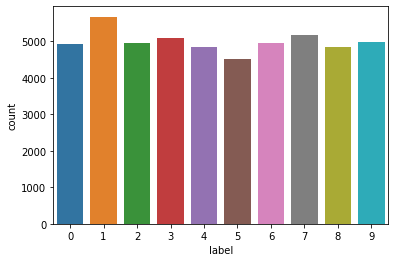

In [12]:
sns.countplot(data=label_df, x='label')

`-` 1(가장 많음)과 5(가장 적음)를 제외하면 라벨별 개수는 비슷하다

In [ ]:
def show_3Dimage(
        _3d_points_data: h5py._hl.files.File, 
        id: int, 
        labels: Optional[Sequence] = None
    ) -> None:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    _3d_points_image = _3d_points_data[str(id)][:]
    x = _3d_points_image[:, 0]
    y = _3d_points_image[:, 1]
    z = _3d_points_image[:, 2]
    ax.scatter(x, y, z, alpha=0.04)

    if labels is not None:
        label = labels[id]
        ax.set_title(label, fontsize=16)
    plt.show()

- 3차원 이미지

In [ ]:
show_3Dimage(all_points, 24983, target)

NameError: ignored

In [ ]:
show_3Dimage(all_points, 49977, target)

In [ ]:
show_3Dimage(all_points, 311, target)

`-` train 이미지는 yz 평면에 숫자를 그린 후 x축으로 팽창되어 있다

`-` test 이미지는 그럴 수도 있고 아닐 수도 있어서 적절한 변환이 필요하다

`-` 6과 9는 뒤집어져 있으면 구분이 안되지만 위와 같이 옆으로 누워있는 3D 이미지도 존재한다

`-` 보통, 글자 6을 쓸 때 막대기부터 쓰고 9는 동그라미부터 쓴다

`-` 6의 경우 막대기가 강조되어 있으며 9의 경우 동그라미가 강조되어 있다 

`-` 2와 5도 뒤집어져 있으면 구분이 안될 수 있다

`-` 나머지는 구분이 잘 된다

- 3차원 점의 분포 확인 (train data)

- x의 최댓값, 최솟값의 범위

In [ ]:
x_data = 0
for i in tqdm(range(50000)):
    data = all_points[str(i)][:]
    if 0.14 <= np.max(data[:, 0]) < 0.16 and -0.16 <= np.min(data[:, 0]) <= -0.14:
        x_data += 1

In [ ]:
x_data

- y, z의 range 분포

In [ ]:
y_data, z_data = [], []
for i in tqdm(range(50000)):
    data = all_points[str(i)][:]
    yy = np.max(data[:, 1]) - np.min(data[:, 1])
    zz = np.max(data[:, 2]) - np.min(data[:, 2])
    y_data.append(yy)
    z_data.append(zz)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.boxplot(y_data)
ax2.boxplot(z_data)
plt.show()

`-` x의 range는 대략 0.3인 반면 y의 range는 다양한 편이다

`-` z의 range는 대략 1이다

## 데이터 전처리

`-` 위의 시각화를 보면 3차원이 아니라 2차원이더라도 숫자를 구분할 수 있을 듯하다

`-` 3차원 points를 2차원 이미지로 변경하자

`-` pretrained model도 사용할 수 있으며 파라미터도 더 적어진다

`-` [$\star$] 지금부터의 설명은 `근사적`으로 3차원 점들을 2차원 이미지로 만드는 방법에 대한 것이다 [$\star$]

### 3D points $\to$ 2D points 

`-` 3D points는 축 하나의 범위가 -0.15 ~ 0.15인 경우와 그렇지 않은 경우로 나뉜다

`-` 전자의 경우 -0.15 ~ 0.15의 범위를 가지는 축을 제외한 나머지 두 축이 구성하는 평면에 3차원 점들을 정사영시키면 된다 

`-` 후자의 경우 특이값 분해 또는 고유값 분해를 이용하여 2차원 점으로 만든다 (고유값 분해가 더 낫다)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def z_scale(_3d_points: npt.NDArray) -> npt.NDArray:
    """_3d_points == [[x1, y1, z1], [x2, y2, z2], ..., [xn, yn, zn]]"""
    scaled_points = []

    for i in range(3):
        p = _3d_points[:, i]
        pp = (p - np.mean(p)) / np.std(p)
        scaled_points.append(pp)

    scaled_points = np.column_stack(tuple(scaled_points))
    return scaled_points

In [ ]:
def svd_3d_to_2d(_3d_points: npt.NDArray) -> npt.NDArray:
    """SVD를 이용하여 3차원 점을 2차원 점으로 차원 축소"""
    X = _3d_points
    U, d, V = np.linalg.svd(X.T @ X)
    V_tilde = np.column_stack((-V[:, 1], -V[:, 0]))  ## 각도 조절
    _2d_points = X @ V_tilde
    return _2d_points

In [ ]:
def eig_3d_to_2d(_3d_points: npt.NDArray) -> npt.NDArray:
    """고유값 분해를 이용하여 3차원 점을 2차원 점으로 차원 축소"""
    X = _3d_points
    Lambda, Psi = np.linalg.eig(X.T @ X)
    _1st, _2nd, _3rd = sorted(Lambda, key = lambda x: -x)  ## 내림차순 정렬
    idx_1st = np.where(Lambda == _1st)
    idx_2nd = np.where(Lambda == _2nd)
    
    Psi_tilde = np.column_stack((-Psi[:, idx_2nd].squeeze(), -Psi[:, idx_1st].squeeze()))  ## 각도 조절
    _2d_points = X @ Psi_tilde
    return _2d_points

In [ ]:
def show_2Dimages(
        _3d_points_data: h5py._hl.files.File, 
        id: int, 
        scaling: bool = False
    ) -> None:
    """3D 이미지에 특이값 분해, 고유값 분해, PCA를 각각 수행하고 시각화"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
    pca = PCA(n_components=2)

    X = _3d_points_data[str(id)][:]
    if scaling:
        X = z_scale(X)

    svd_z = svd_3d_to_2d(X)
    eig_z = eig_3d_to_2d(X)
    pca_z = pca.fit_transform(X)

    ax1.plot(svd_z[:,0], svd_z[:,1], '.', alpha=0.5)
    ax2.plot(eig_z[:,0], eig_z[:,1], '.', alpha=0.5)
    ax3.plot(pca_z[:,0], pca_z[:,1], '.', alpha=0.5)

    ax1.set_title('SVD')
    ax2.set_title('Eigen')
    ax3.set_title('PCA')
    plt.show()    

In [ ]:
show_2Dimages(all_points, 41483)

In [ ]:
show_2Dimages(all_points, 41483, scaling=True)

`-` SVD와 고유값 분해는 output의 차이가 존재한다 

`-` 고유값 분해가 SVD 보다 원본 이미지를 잘 보존하는 듯하다

`-` PCA는 고유값 분해와 output이 동일하다 (각도만 다르다)

`-` 식별 가능한 이미지를 생성하기엔 스케일링을 하지 않는 것이 더 낫다

`-` 스케일링을 하면 팽창된 부분 (-0.15 ~ 0.15)의 range가 다른 axis의 range와 비슷해져 원본 이미지를 보존하지 못한다 (스케일링 한 것과 안 한것을 비교하면 바로 알 수 있음)

`-` [$\star$] 위 코드의 목적은 데이터의 분산을 보존하는 것이 아니라 `식별 가능한 이미지`를 `보존`하는 것이다 [$\star$]

- just 정사영

In [ ]:
def project_point2plane(_3d_points: npt.NDArray) -> Union[npt.NDArray, None]:
    """
    yz평면에 숫자를 생성하고 x축으로 팽창시킨 경우 (x축의 범위: -0.15 ~ 0.15) 
    yz평면에 3차원 점들을 정사영
    """
    x = _3d_points[:, 0]
    y = _3d_points[:, 1]
    z = _3d_points[:, 2]

    xmax = np.max(x)
    xmin = np.min(x) 

    if 0.14 <= xmax <= 0.16 and -0.16 <= xmin <= -0.14:
        new_x = y
        new_y = z
    else:
        return None

    _2d_points = np.column_stack((new_x, new_y))
    return _2d_points

In [ ]:
show_3Dimage(all_points, 803, target)

In [ ]:
z = project_point2plane(all_points['803'][:])
plt.plot(z[:, 0], z[:, 1], '.')
plt.show()

`-` 정사영이 잘 수행되었다

`-` 이와 별개로 노이즈가 있는 데이터가 존재함을 알 수 있다

### 2D points $\to$ 2D image

`-` size $\times$ size 크기의 격자를 만들고 격자 내부의 해당하는 점의 개수를 픽셀값으로 하여 2D 이미지를 만들겠다

`-` 격자의 네 꼭짓점은 (xmax, ymax), (xmax, ymin), (xmin, ymax), (xmin, ymin)으로 할 수도 있다

`-` 하지만 그렇게 하면 이미지의 x축, y축 비율을 1:1로 맞추는 것이기에 원본 이미지를 왜곡하게 된다

In [ ]:
show_3Dimage(all_points, 71, target)

In [ ]:
z = eig_3d_to_2d(all_points['71'][:])
plt.plot(z[:, 0], z[:, 1], '.')
plt.show()

In [ ]:
print(
    f"""
    xmax: {np.max(z[:, 0])}
    xmin: {np.min(z[:, 0])}
    ymax: {np.max(z[:, 1])}
    ymin: {np.min(z[:, 1])}
    """)

`-` 예컨대 위의 이미지는 직사각형이지만 size $\times$ size 크기의 이미지로 만드는 과정에서 왜곡이 생긴다

`-` 네 꼭짓점을(xmax, ymax), (xmax, ymin), (xmin, ymax), (xmin, ymin)로 하면 직사각형이지만 최종적으론 정사각형이 되야하므로 당연히 원본 이미지가 왜곡된다

`-` 즉, x축과 y축의 원본 비율이 어떻든 최종 이미지에선 1:1이 되는 것이다

`-` 네 꼭짓점이 직사각형이 아닌 정사각형을 구성하도록 설정해야 스케일을 보존할 수 있다

In [ ]:
z = eig_3d_to_2d(all_points['71'][:])
plt.figure(figsize=(5, 5))
plt.plot(z[:, 0], z[:, 1], '.')
plt.xlim(np.min(z), np.max(z))
plt.ylim(np.min(z), np.max(z))
plt.show()

`-` 약간의 여백을 삽입할 수도 있다 (여백을 삽입해도 네 꼭짓점이 정사각형을 이루어야 함)

In [ ]:
z = eig_3d_to_2d(all_points['71'][:])
delta = (np.max(z) - np.min(z)) * 0.05  ## 상하좌우 각각에 축 범위의 5% 만큼 여백을 삽입
plt.figure(figsize=(5, 5))
plt.plot(z[:, 0], z[:, 1], '.')
plt.xlim(np.min(z) - delta, np.max(z) + delta)
plt.ylim(np.min(z) - delta, np.max(z) + delta)
plt.show()

`-` **점을 평행이동하여 중앙으로 옮길 필요가 있다**

`-` 그렇지 않으면 여백의 밸런스가 맞지 않는다

`-` 한편, 네 꼭짓점을 최댓값과 최솟값을 기준으로 하는 것은 너무 위험한 것 같다 (이상치에 매우 민감함)

`-` 점이라도 하나 엉뚱한데 찍혀있으면 이미지가 왜곡된다

`-` 최댓값 대신에 사분위수와 같이 이상치에 덜 민감한 값을 사용하겠다

`-` 사분위수를 벗어나는 점들은 이상치(noise)로 간주하여 이미지를 생성할 때 무시하자

`-` 이때 사분위수는 x, y 좌표값을 공통으로 사용하여 계산한다 (정사각형 도화지를 만들 것이므로)

- 점을 중앙으로 평행이동

`-` 이미지를 그릴 도화지는 정사각형이다

`-` 기본적으로 정사각형의 네 꼭짓점의 좌표는 (pmax, pmax), (pmax, pmin), (pmin, pmax), (pmin, pmin)이다 

`-` $\text{pmax} = \max(\text{xmax}, \text{ymax})$, pmin도 마찬가지의 방법으로 생성

`-` 이때, 로버스트한 결과를 얻기위해 최댓값과 최솟값 대신 사분위수(quantile)를 사용한다

`-` 또한, 동일한 크기의 여백을 상하좌우에 추가한다

`-` 즉, 최종적인 도화지의 네 꼭짓점의 좌표는 $(\text{pqmax} + \alpha, \text{pqmax} + \alpha), (\text{pqmax} + \alpha, \text{pqmin} - \alpha), (\text{pqmin} - \alpha, \text{pqmax} + \alpha), (\text{pqmin} - \alpha, \text{pqmin} - \alpha)$이다

`-` 점을 중앙으로 옮긴다는 것은 좌우의 여백을 같게 하고 상하의 여백을 같게 하는 것으로 생각하자

`-` 즉, $|\text{pqmax} + \alpha - \text{xqmax}| = |\text{pqmin} - \alpha - \text{xqmin}|$ and $|\text{pqmax} + \alpha - \text{yqmax}| = |\text{pqmin} - \alpha - \text{yqmin}|$

In [ ]:
def move_points_to_center(
        points : npt.NDArray, 
        pmax: float, 
        pmin: float, 
        xmax: float, 
        xmin: float, 
        ymax: float, 
        ymin: float
    ) -> npt.NDArray:
    """
    points == [[x1, y1], [x2, y2], ..., [xn, yn]] 
    pmax == max(xmax, ymax), pmin == min(xmin, ymin)
    (pmax, pmax), (pmax, pmin), (pmin, pmax), (pmin, pmin)을 네 점으로 하는 사각형을 기준으로 하여
    정사각형 내부에 존재하는 points를 중앙으로 평행이동
    {(pmax >= xmax, ymax) and (pmin =< xmin, ymin)}으로 주어지길 기대
    """
    if pmax < xmax or pmax < ymax or pmin > xmin or pmin > ymin:
        return points

    new_points = np.zeros_like(points)
    left_right_blank = ((pmax - xmax) + (xmin - pmin)) / 2  ## 좌우 여백
    up_down_blank = ((pmax - ymax) + (ymin - pmin)) / 2  ## 상하 여백
    new_points[:, 0] = points[:, 0] + ((pmax - xmax) - left_right_blank)
    new_points[:, 1] = points[:, 1] + ((pmax - ymax) - up_down_blank)
    return new_points

- 2D points $\to$ 2D image

In [ ]:
def points2image(
        _2d_points: npt.NDArray, 
        x_y: Tuple[int, int] = (28, 28)
    ) -> npt.NDArray:
    """
    _2d_points == [[x1, y1], [x2, y2], ..., [xn, yn]]
    max를 최댓값 대신 (1 - 100q)% 사분위수, min을 최솟값 대신 100q% 사분위수를 사용
    pmax, pmin = np.max(_2d_points), np.min(_2d_points)
    (pmax, pmax), (pmax, pmin), (pmin, pmax), (pmin, pmin)을 네 점으로 하는 사각형 생성
    사각형을 x_y[0] * x_y[1] 크기의 격자로 만들고 칸 하나를 픽셀로 생각하여 이미지를 생성
    픽셀값은 해당 칸에 존재하는 점의 개수로 설정
    """
    q = 0.01
    x = _2d_points[:, 0]
    y = _2d_points[:, 1]
    xmax = np.quantile(x, 1 - q)
    xmin = np.quantile(x, q)
    ymax = np.quantile(y, 1 - q)
    ymin = np.quantile(y, q)
    pmax = np.max([xmax, ymax])
    pmin = np.min([xmin, ymin])

    ## 이미지의 상하좌우에 공백을 삽입
    ratio = 0.05
    delta = np.abs(pmax - pmin) * ratio
    pmax += delta
    pmin -= delta

    ## 이미지를 중앙으로 평행이동
    new_2d_points = move_points_to_center(_2d_points, pmax, pmin, xmax, xmin, ymax, ymin)
    x = new_2d_points[:, 0]
    y = new_2d_points[:, 1]

    ## (pmax, pmax), (pmax, pmin), (pmin, pmax), (pmin, pmin)을 네 점으로 하는 사각형 생성
    ## 해당 사각형을 x_y 크기의 격자로 만들고 칸 하나를 픽셀로 생각하여 이미지를 생성
    x_linspace = np.linspace(pmin, pmax, x_y[0] + 1)
    y_linspace = np.linspace(pmin, pmax, x_y[1] + 1)
    images = np.zeros(x_y)  ## 이미지 배열 선언

    x_idx = np.searchsorted(x_linspace, x) - 1  ## -1 ~ x_y[0] 
    y_idx = np.searchsorted(y_linspace, y) - 1  ## -1 ~ x_y[1]   

    ## 픽셀값은 해당 칸에 존재하는 점의 개수로 설정 
    for xx, yy in zip(x_idx, y_idx):
        if 0 <= xx < x_y[0] and 0 <= xx < x_y[1]:  ## x: 0 ~ x_y[0] - 1, y: 0 ~ x_y[1] - 1
            images[x_y[1] - yy - 1][xx] += 1
    return images

In [ ]:
show_3Dimage(test_points, 50023)

In [ ]:
z = eig_3d_to_2d(test_points['50023'][:])
delta = (np.max(z) - np.min(z)) * 0.05  ## 상하좌우 각각에 축 범위의 5% 만큼 여백을 삽입
plt.figure(figsize=(5, 5))
plt.plot(z[:, 0], z[:, 1], '.')
plt.xlim(np.min(z) - delta, np.max(z) + delta)
plt.ylim(np.min(z) - delta, np.max(z) + delta)
plt.show()

In [ ]:
image = points2image(z, x_y=[28, 28])  
plt.imshow(image)

`-` size가 너무 크면 윤곽선만 남는다 (대부분의 점들이 윤곽선 근처에 모여있음)

`-` size를 작게 하고 torchvision 같은 패키지를 활용해 크게 만드는 것이 낫다

In [ ]:
image = points2image(z, x_y=[112, 112])  
plt.imshow(image)

- 3D points $\to$ 2D points $\to$ 2D image

`-` 여기서의 고민은 train image를 생성함에 있어 단순 정사영을 사용할지 고유값 분해를 이용한 차원 축소를 사용할지이다

`-` 근데 단순 정사영이 나은 것 같다

`-` 고유값 분해를 사용하면 숫자의 방향이 3D 일때와 달라질 수 있기 때문이다

`-` 그리고 단순 정사영과 고유값 분해를 통한 차원 축소는 이미지가 1인 경우를 제외하면 큰 차이가 있진 않다

In [ ]:
def get_2d_images(
        _3d_points_data: h5py._hl.files.File, 
        labels: Sequence[int],
        x_y: Tuple[int, int] = (28, 28)
    ) -> npt.NDArray:   
    images = []
    for i in tqdm(labels):
        _3d_points = _3d_points_data[str(i)][:]
        _2d_points = project_point2plane(_3d_points)  ## 단순 정사영

        if _2d_points is None:
            _2d_points = eig_3d_to_2d(_3d_points)  ## 고유값 분해를 통한 차원 축소

        _2d_image = points2image(_2d_points, x_y)  ## 2D points -> 2D image
        images.append(_2d_image)
    images = np.array(images, dtype=np.float32)
    return images

In [ ]:
train_images = get_2d_images(all_points, range(50000))

In [ ]:
train_images.shape

In [ ]:
test_images = get_2d_images(test_points, range(50000, 90000))

In [ ]:
test_images.shape

- 2D 이미지 시각화

In [ ]:
def show_random_images(
        images: npt.NDArray,
        labels: npt.NDArray[np.int_], 
        label_condition: Optional[int] = None,
        nrows: int = 4, 
        ncols: int = 4
    ) -> None:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2, nrows*2))
    if label_condition is not None:
        images = images[labels == label_condition].copy()
        labels = labels[labels == label_condition].copy() 
    idx_list = list(map(int, np.random.uniform(size=nrows*ncols) * images.shape[0]))

    for idx, ax in zip(idx_list, axs.flatten()):
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(labels[idx])
        ax.imshow(images[idx])       
    fig.tight_layout()

- 숫자 6 이미지

In [ ]:
show_random_images(train_images, target, 6)

- 숫자 9 이미지

In [ ]:
show_random_images(train_images, target, 9)

- 숫자 2와 5

- 숫자 2 이미지

In [ ]:
show_random_images(train_images, target, 2)

- 숫자 5 이미지

In [ ]:
show_random_images(train_images, target, 5)

- Test 이미지

In [ ]:
show_random_images(test_images, ['Unknown'] * 50000)

- 이미지를 벡터로 변환 후 csv파일로 저장

In [ ]:
train_vectors = train_images.reshape(-1, 28*28)
test_vectors = test_images.reshape(-1, 28*28)

In [ ]:
train_vectors.shape, test_vectors.shape

In [ ]:
train_data = pd.DataFrame([])
train_data['ID'] = list(range(50000))

test_data = pd.DataFrame([])
test_data['ID'] = list(range(50000, 90000))

In [ ]:
for i in range(28*28):
    train_data[f'X{i}'] = train_vectors[:, i]
    test_data[f'X{i}'] = test_vectors[:, i]

In [ ]:
# train_data.to_csv('./Data/train_array3.csv', index=False)
# test_data.to_csv('./Data/test_array3.csv', index=False)

## 모델 학습 준비

In [13]:
!pip install albumentations==1.2.1
!pip install adabelief-pytorch
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 27.0 MB/s 


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.modules.loss import _WeightedLoss
from torch.optim import Optimizer
from torch.nn import Module
 
import albumentations as A
from albumentations import Compose
from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import timm
from adabelief_pytorch import AdaBelief

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [16]:
## 정확도 계산
def accuracy(true: npt.NDArray[np.int_], pred: npt.NDArray[np.int_]) -> float:
    return np.sum(true == pred) / len(true)

In [17]:
def seed_everything(seed: int = 22) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [18]:
def clear_gpu() -> None:
    gc.collect()
    torch.cuda.empty_cache()

- 학습 이미지

`-` 3d point 데이터를 보면 숫자마다 점의 개수가 다르다

`-` 그에 따라, 픽셀의 최댓값도 다르다

`-` 이미지마다 픽셀의 최댓값을 1로 맞춰주어 차이를 줄여주겠다

`-` 그러면 어떤 영역에 점이 더 많이 분포하는지가 차이점이 된다

`-` 최댓값을 255로 해도 되지만 어차피 정규화를 할 것이므로 미리 1로 맞춰주겠다

In [19]:
def change_max_pixel_value(image, new_max_pixel_value=1.0):
    max_pixel_value = np.max(image)
    if max_pixel_value > new_max_pixel_value:
        image *= (new_max_pixel_value / max_pixel_value)
    return image

In [20]:
train_data = pd.read_csv('./Data/train_array3.csv').drop('ID', axis=1)
test_data = pd.read_csv('./Data/test_array3.csv').drop('ID', axis=1)

- 이미지 픽셀의 최댓값을 1로 변경

In [21]:
for i in tqdm(range(50000)):
    train_data.loc[i, :] = change_max_pixel_value(train_data.loc[i, :])

  0%|          | 0/50000 [00:00<?, ?it/s]

In [22]:
for i in tqdm(range(40000)):
    test_data.loc[i, :] = change_max_pixel_value(test_data.loc[i, :])

  0%|          | 0/40000 [00:00<?, ?it/s]

- 이미지의 채널을 3차원으로 변경

In [23]:
train_images = train_data.to_numpy().reshape(-1, 28, 28, 1)
test_images = test_data.to_numpy().reshape(-1, 28, 28, 1)

In [24]:
train_images = np.concatenate([train_images, train_images, train_images], axis=-1).astype(np.float32)
test_images = np.concatenate([test_images, test_images, test_images], axis=-1).astype(np.float32)

In [25]:
train_images.shape, test_images.shape

((50000, 28, 28, 3), (40000, 28, 28, 3))

- 데이터 셋과 데이터 로더

In [26]:
class CustomDataset(Dataset):
    def __init__(
        self,
        images: Sequence[npt.NDArray], 
        labels: Optional[Sequence[int]] = None,
        transforms: Optional[Callable[[Compose], Dict[str, Tensor]]] = None
    ) -> None:
        self.images = images
        self.labels = labels
        self.transforms = transforms
    
    def __getitem__(self, idx: int) -> Union[Tuple[Tensor, int], Tensor]:
        image = self.images[idx]    
        if self.transforms is not None:
            image = self.transforms(image=image)['image']  ## albumentations 사용
        image = torch.tensor(image, dtype=torch.float32)

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.int64)
            return image, label
        return image  ## test는 라벨이 없다
    
    def __len__(self) -> int:
        return len(self.images)  

In [27]:
def get_dataloader(
        X: Sequence[npt.NDArray], 
        y: Optional[Sequence[int]] = None, 
        transforms: Optional[Callable[[Compose], Dict[str, Tensor]]] = None, 
        shuffle_dataloader: bool = True
    ) -> DataLoader:
    dataset = CustomDataset(X, y, transforms)    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle_dataloader)
    return dataloader

- 데이터 변환

`-` https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/transforms.py

`-` 위의 링크를 통해 변환함수들의 구조를 확인하자

`-` 회전, 뒤집기를 제외한 기하학적 변형은 6과 9의 구분을 어렵게 만드므로 사용하지 않겠다 (i.g. Affine)

In [28]:
RGB_MEAN = [np.mean((train_images[..., i])) for i in range(3)] 
RGB_STD = [np.std(train_images[..., i]) for i in range(3)]  

In [34]:
def sharpen(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    transformed_image = cv2.filter2D(image, -1, kernel)
    transformed_image = np.clip(transformed_image, 0.0, 1.0)
    return transformed_image

In [30]:
class Sharpen(ImageOnlyTransform):
    def __init__(
        self,
        always_apply=False,
        p=1.0
    ): 
        super(Sharpen, self).__init__(always_apply, p)
    
    def apply(self, image, **params):
        return sharpen(image)

In [59]:
## 데이터 변환 방식을 정의 (Agumentation)
def get_transforms(phase: str) -> Compose:
    if phase == 'train':
        transforms = A.Compose([
            A.RandomSnow(brightness_coeff=2.0, p=0.2),
            A.Resize(IMAGE_H, IMAGE_W),
            Sharpen(),
            A.HorizontalFlip(p=0.5), 
            A.VerticalFlip(p=0.5),  
            A.Rotate(limit=90, border_mode=cv2.BORDER_CONSTANT, p=0.75),  ## 무작위로 -limit~limit 각도 회전
            A.RandomGamma(gamma_limit=(85, 115), p=0.5),  ## X -> (X ** gamma_list[0] ~ X ** gamma_list[1])
            A.GaussNoise(var_limit=(0.0, 0.002), p=0.3),  ## X -> X + gauss
            A.Normalize(mean=RGB_MEAN, std=RGB_STD, max_pixel_value=1.0), 
            ToTensorV2() ## (H X W X C) 차원의 numpy array를 (C X H X W) 차원의 torch tensor로 변환  
        ])
    elif phase == 'valid':
        transforms = A.Compose([
            A.Resize(IMAGE_H, IMAGE_W),
            Sharpen(),
            A.Normalize(mean=RGB_MEAN, std=RGB_STD, max_pixel_value=1.0), 
            ToTensorV2()  
        ])
        
    return transforms ## 데이터 변환 방식을 반환

- 조기 중단

In [36]:
## Copyright (c) 2018 Bjarte Mehus Sunde
## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 횟수 이후로 validation score가 개선되지 않으면 학습을 조기 중단"""
    mode_dict = {'min':-1, 'max':1}
    score_metrics = [
                      'accuracy',
                    ]

    def __init__(
        self, 
        patience: int = 7, 
        monitored_quantity: str = 'loss', 
        mode: str = 'min', 
        min_delta: float = 0.0, 
        path: str = './weight', 
        model_name: str = '', 
        current_fold: int = 1
    ) -> None:
        """
        Args:
            patience (int): score가 개선될 때까지 기다리는 에폭
                            Default: 7
                          
            monitored_quantity (str): 값의 변화를 모니터링할 수치(score)
                            Default: 'loss'

            mode (str): score를 개선시킬 방식
                            Default: 'min'

            min_delta (float): 개선되었다고 인정되는 score의 최소 변화
                            Default: 0.0

            path (str): checkpoint 공통 저장 경로
                            Default: './weight'

            model_name (str): 학습시킬 모델의 이름
                            Default: ''

            current_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.direction = self.mode_dict[mode]
        self.monitored_quantity = monitored_quantity
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None  ## 평가지표 (i.g. accuracy)
        self.early_stop = False
        self.min_delta = min_delta
        self.path = path
        self.model_name = model_name
        self.current_fold = current_fold

    def __call__(
        self, 
        model: Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        ## score는 클수록 좋다
        if self.monitored_quantity == 'loss':
            score = valid_loss * self.direction
        elif self.monitored_quantity in self.score_metrics:
            score = valid_metric_score * self.direcion
        else:
            score = None

        ## score가 개선되었는지 확인
        if score <= self.best_score + self.min_delta: 
            self.counter += 1 
            if self.counter > self.patience:  ## 만약 score가 개선되지 않은 에폭이 patience 횟수보다 크다면 조기 중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(model, valid_loss, valid_metric_score) 
            self.counter = 0  ## score가 개선되었으므로 0으로 변경

    def save_checkpoint(
        self, 
        model: Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        """validation score가 개선되면 모델을 저장"""
        torch.save(model.state_dict(), self.path + f'/{self.model_name}_best_{self.current_fold}.pt') 
        self.valid_loss = valid_loss  ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.valid_metric_score = valid_metric_score  ## 이때의 valid metric score도 변경해준다

    def check_early_stop(self) -> bool:
        return self.early_stop

    def set_fold(self, current_fold: int) -> None:
        self.current_fold = current_fold

    def reset_score(self) -> None:
        """다음 fold 학습을 위해 score 관련 파라미터를 초기화"""
        self.counter = 0
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None
        self.early_stop = False

## 모델 K겹 교차검증

In [37]:
from sklearn.model_selection import StratifiedKFold

- Kfold와 손실 함수

In [38]:
skfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

- early stopping

In [39]:
early_stopping = EarlyStopping(patience=4,
                               path=SAVE_PATH,
                               model_name=MODEL_NAME,
                               current_fold=1)  ## patience 횟수 에폭 후에도 검증 손실이 작아지지 않으면 조기 중단

In [40]:
def train(
        model: Module,
        dataloader: DataLoader, 
        optimizer: Optimizer, 
        loss_fn: _WeightedLoss, 
        scheduler: Optional[_LRScheduler] = None
    ) -> Tuple[Module, float]:
    """dataloader의 데이터로 모델을 학습시킨 후 학습된 모델과 평균 배치 훈련 오차를 반환"""  
    train_loss = 0.0  ## mini-batch 평균 훈련 오차 
    model = model.to(device)
    model.train()

    for X, y in tqdm(dataloader):  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = loss_fn(y_hat, y)  
        optimizer.zero_grad()  ## 그래디언트 초기화
        loss.backward()   ## 미분
        optimizer.step()  ## 업데이트
        train_loss += (loss.item() / len(dataloader)) 
  
    ## 에폭마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_loss

In [41]:
def evaluate(
        model: Module, 
        dataloader: DataLoader, 
        loss_fn: _WeightedLoss
    ) -> Tuple[float, float]:
    """dataloader의 데이터를 모델이 평가한 후 평균 배치 검증 오차와 정확도를 반환"""
    valid_acc, valid_loss = 0.0, 0.0  ## mini-batch 평균 검증 오차와 정확도 
    model = model.to(device)
    model.eval()  

    with torch.no_grad():  ## 역전파를 계산할 필요가 없으니까
        for X, y in dataloader:  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)  
            acc = accuracy(y.cpu().numpy(), y_hat.cpu().numpy().argmax(-1))    
            valid_loss += loss.item() / len(dataloader)
            valid_acc += (acc * len(y) / len(dataloader.dataset))  ## 각 배치마다 정확도(정답 개수 / 전체 개수)

    return valid_loss, valid_acc

In [60]:
def kfold_cross_validate(
        model: Module, 
        X: Sequence[npt.NDArray], 
        y: Sequence[int], 
        skfold: StratifiedKFold, 
        loss_fn: _WeightedLoss, 
        early_stopping: EarlyStopping
    ) -> Tuple[Module, List[List[float]], List[List[float]]]:
    """K겹 교차검증을 통해 모델의 성능을 평가하고 학습된 모델과 폴드별 훈련 손실, 폴드별 검증 손실을 반환"""
    seed_everything(SEED)  ## 정확한 재현을 위함
    num_folds = skfold.n_splits  ## 폴드의 개수
    fold_valid_loss = []  ## 폴드별 가장 작은 검증 손실
    fold_valid_acc = []  ## 폴드별 가장 작은 검증 손실을 가질 때의 정확도
    fold_train_losses_per_epoch = [[] for _ in range(num_folds)]  ## 폴드별 1 에폭에 따른 훈련 배치 손실
    fold_valid_losses_per_epoch = [[] for _ in range(num_folds)]  ## 폴드별 1 에폭에 따른 검증 배치 손실

    for fold, (train_idx, valid_idx) in enumerate(skfold.split(X, y)):
        print(f'[{fold + 1} / {num_folds}] Fold Training......')

        ## 메모리 절약
        clear_gpu()
        
        ## 훈련 데이터와 검증 데이터로 분할
        X_train, X_valid = X[train_idx], X[valid_idx] 
        y_train, y_valid = y[train_idx], y[valid_idx]

        ## Dataloader
        train_dataloader = get_dataloader(X_train, y_train, get_transforms('train'))
        valid_dataloader = get_dataloader(X_valid, y_valid, get_transforms('valid'))

        ## 딥러닝 모델의 기본 가중치 불러오기
        model.load_state_dict(torch.load(MODEL_DEFAULT_WEIGHT_PATH, map_location=device))

        ## optimizer, scheduler (수동으로 선택)
        optimizer = AdaBelief(model.parameters(),
                      lr=LEARNING_RATE,  ## LEARNING_RATE
                      eps=1e-8,
                      weight_decay=1e-3,
                      betas=(0.9, 0.999),
                      weight_decouple=True,
                      rectify=False,
                      print_change_log=False)
        
        scheduler = None

        ## early stop, 다음 폴드 학습을 위해 score 관련 파라미터 초기화
        early_stopping.reset_score()
        early_stopping.set_fold(fold + 1)  
        
        ## 폴드마다 모델 학습
        for epoch in tqdm(range(1, NUM_EPOCHS + 1)): ## (배치사이즈 X 에폭) 만큼 훈련시킴           
            model, train_loss = train(model, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
            valid_loss, valid_acc = evaluate(model, valid_dataloader, loss_fn)  ## 모델 평가
            fold_train_losses_per_epoch[fold].append(train_loss) 
            fold_valid_losses_per_epoch[fold].append(valid_loss)  

            print_score_condition = (epoch == 1 or epoch % 1 == 0 or epoch == NUM_EPOCHS)  ## 10의 배수값을 가지는 에폭마다 score 출력
            score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  valid acc = {valid_acc:.5f}'

            ## 평균 배치 훈련 오차와 검증 오차 출력
            if print_score_condition:  
                print(score_information)  
                
            ## 에폭마다 early stopping 실행
            early_stopping(model, valid_loss, valid_acc)  ## __call__ function
            if early_stopping.check_early_stop(): 
                if not print_score_condition:  ## 이미 출력한 에폭에 대해 중복으로 출력하지 않기 위함
                    print(score_information) 
                print('Early Stopping!')
                break 

        fold_valid_loss.append(early_stopping.valid_loss)  ## 폴드별 가장 작은 검증 손실
        fold_valid_acc.append(early_stopping.valid_metric_score)  ## 폴드별 가장 작은 검증 손실일 때의 정확도
         
        ## 폴드별 학습 및 검증 종료시 가장 작은 검증 손실과 이때의 정확도를 출력
        print(f'{fold + 1} Fold -> Best Valid Loss: {early_stopping.valid_loss:.5f} Valid Accuracy: {early_stopping.valid_metric_score:.5f}', end='\n\n')
        
    ## 폴드별 가장 손실이 작은 모델의 평균 검증 손실과 이때의 평균 정확도를 출력
    print(f'{num_folds} Fold Mean Valid Best Loss: {np.mean(fold_valid_loss):.5f}')
    print(f'{num_folds} Fold Mean Valid Accuracy: {np.mean(fold_valid_acc):.5f}')

    return model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch

- 모델 선언 및 가중치 저장

In [43]:
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES)
torch.save(model.state_dict(), MODEL_DEFAULT_WEIGHT_PATH)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth


- 모델 K겹 교차검증

`-` 이미지 $112 \times 112$ 크기 기준 에폭 하나당 코랩에서 5분쯤 걸린다

`-` 3시 10분 시작

In [61]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = kfold_cross_validate(model, train_images, target, skfold, loss_fn, early_stopping)

[1 / 5] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.28608  valid loss = 0.57524  valid acc = 0.90620


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  2]  train loss = 0.64719  valid loss = 0.47371  valid acc = 0.93780


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  3]  train loss = 0.55235  valid loss = 0.44939  valid acc = 0.94460


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  4]  train loss = 0.51124  valid loss = 0.42181  valid acc = 0.95380


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  5]  train loss = 0.48035  valid loss = 0.42280  valid acc = 0.95070


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  6]  train loss = 0.45898  valid loss = 0.41488  valid acc = 0.95370


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  7]  train loss = 0.44785  valid loss = 0.40789  valid acc = 0.95600


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  8]  train loss = 0.43414  valid loss = 0.38827  valid acc = 0.96570


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  9]  train loss = 0.42274  valid loss = 0.37716  valid acc = 0.96810


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 10]  train loss = 0.41287  valid loss = 0.37156  valid acc = 0.97020


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 11]  train loss = 0.40345  valid loss = 0.36400  valid acc = 0.97480


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 12]  train loss = 0.39482  valid loss = 0.36275  valid acc = 0.97380


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 13]  train loss = 0.38816  valid loss = 0.36546  valid acc = 0.97280


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 14]  train loss = 0.38039  valid loss = 0.35597  valid acc = 0.97740


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 15]  train loss = 0.37669  valid loss = 0.35958  valid acc = 0.97410


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 16]  train loss = 0.37254  valid loss = 0.35386  valid acc = 0.97650


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 17]  train loss = 0.36835  valid loss = 0.35250  valid acc = 0.97660


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 18]  train loss = 0.36370  valid loss = 0.34925  valid acc = 0.97890


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 19]  train loss = 0.36115  valid loss = 0.35073  valid acc = 0.97710


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 20]  train loss = 0.35939  valid loss = 0.34828  valid acc = 0.97900


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 21]  train loss = 0.35334  valid loss = 0.34795  valid acc = 0.97820


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 22]  train loss = 0.35162  valid loss = 0.34858  valid acc = 0.97890


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 23]  train loss = 0.34807  valid loss = 0.34463  valid acc = 0.97940


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 24]  train loss = 0.34625  valid loss = 0.34175  valid acc = 0.98040


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 25]  train loss = 0.34313  valid loss = 0.34707  valid acc = 0.97910


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 26]  train loss = 0.34231  valid loss = 0.35080  valid acc = 0.97630


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 27]  train loss = 0.33987  valid loss = 0.34471  valid acc = 0.97780


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 28]  train loss = 0.33798  valid loss = 0.34955  valid acc = 0.97700


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 29]  train loss = 0.33571  valid loss = 0.34168  valid acc = 0.97940


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 30]  train loss = 0.33562  valid loss = 0.34015  valid acc = 0.98170


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 31]  train loss = 0.33270  valid loss = 0.34148  valid acc = 0.97920


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 32]  train loss = 0.33003  valid loss = 0.34790  valid acc = 0.97820


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 33]  train loss = 0.32910  valid loss = 0.34572  valid acc = 0.97870


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 34]  train loss = 0.32778  valid loss = 0.34215  valid acc = 0.97990


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 35]  train loss = 0.32632  valid loss = 0.34385  valid acc = 0.97970
Early Stopping!
1 Fold -> Best Valid Loss: 0.34015 Valid Accuracy: 0.98170

[2 / 5] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

1234567891011121314

- train loss와 valid loss의 변화를 시각화

In [ ]:
def show_loss_plot(
        fold_train_losses: List[List[float]],
        fold_valid_losses: List[List[float]]
    ) -> None:
    """폴드별로 에폭에 따른 모델의 훈련 손실과 검증 손실의 변화를 시각화"""
    assert len(fold_train_losses) == len(fold_valid_losses)
    num_folds = len(fold_train_losses)
    ncols = 3
    nrows = 1 + (num_folds - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4)) 

    ## 폴드마다 에폭에 따른 훈련 손실과 검증 손실의 변화를 시각화
    for fold, (ax, train_losses, valid_losses) in enumerate(zip(axes.flatten(), fold_train_losses, fold_valid_losses), start=1):
        assert len(train_losses) == len(valid_losses) 
        if fold > num_folds:
            break

        num_epochs = len(train_losses)
        ax.set_title(f'{fold} Fold')
        ax.plot(range(1, num_epochs+1), train_losses, label='Train')
        ax.plot(range(1, num_epochs+1), valid_losses, label='Valid')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    fig.suptitle('Train Loss and Valid Loss', x=0.51, y=1.05, fontsize=15)
    fig.tight_layout()

    ## 남는 서브 플랏 제거
    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

In [ ]:
# show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)

## Test 예측

In [45]:
!pip install ttach

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import ttach as tta

`-` 3차원 이미지를 2차원 이미지로 축소된 결과물이 일반적으로 알고있는 형태와 다르다 (예컨대 6이 거꾸로 뒤집어 있다)

`-` 왜냐하면 같은 라벨이더라도 3차원 상에서 rotate, flip 되어있는 이미지가 존재하기 때문이다

`-` 즉, 3차원 상에서는 동일한 숫자이미지라도 rotate 또는 flip 되어도 구분이 가능하다 (쉽지는 않다...)

`-` 따라서 이미지의 형태를 보고 라벨을 맞춰야 한다 (예컨대 6은 막대기가, 9는 동그라미가 강조되어있다; 그런데 내가 몇개만 확인한거라 아닐수도 있다)

`-` 이미지를 rotate 또는 flip 하더라도 동일하므로 예측해야할 이미지에 roate와 flip을 적용하여 일반화 성능을 올리겠다

In [47]:
def predict(
        model: Module, 
        dataloader: DataLoader, 
        weight_save_path: str, 
        tta_transforms: Optional[tta.base.Compose] = None,
        return_prob: bool = False
    ) -> Tensor:
    """저장된 모델의 가중치를 불러와서 dataloader의 데이터를 예측하여 반환"""
    model = model.to(device) 
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), NUM_CLASSES))  

    for weight_path in tqdm(weight_path_list):
        if MODEL_NAME not in weight_path:  ## 학습시킨 모델의 가중치만 예측하는데 사용
            continue
            
        probs = None
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.eval()

        if tta_transforms is not None:
            tta_model = tta.ClassificationTTAWrapper(model, tta_transforms)
        
        with torch.no_grad(): 
            for X in dataloader:  ## test 데이터는 라벨(y)이 없다
                X = X.to(device) 
                if tta_transforms is not None:
                    y_hat = tta_model(X).cpu().numpy()
                else:
                    y_hat = model(X).cpu().numpy()

                if probs is None:
                    probs = y_hat
                else:
                    probs = np.concatenate([probs, y_hat])

        test_probs += (probs / NUM_FOLDS) 
    test_probs = torch.softmax(torch.tensor(test_probs), dim=1)  ## 각 컬럼별 확률
    _, test_preds = torch.max(test_probs, dim=1)  ## 최댓값과 인덱스

    if return_prob:
        return test_probs  ## 각 컬럼별 확률
    return test_preds  ## 라벨

In [62]:
test_dataloader = get_dataloader(X=test_images, y=None, transforms=get_transforms('valid'), shuffle_dataloader=False)

In [63]:
tta_transforms = tta.Compose(
    [
        tta.Rotate90([0, 90, 180, 270]),
        tta.HorizontalFlip(),
        # tta.VerticalFlip(),
    ]
)

In [ ]:
preds = predict(model, test_dataloader, SAVE_PATH, tta_transforms, return_prob=False)

  0%|          | 0/1 [00:00<?, ?it/s]

In [51]:
test_df['label'] = preds
test_df.head()

,ID,label
0,50000,7
1,50001,2
2,50002,2
3,50003,4
4,50004,9


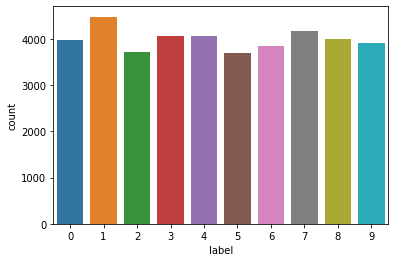

In [52]:
sns.countplot(data=test_df, x='label')

In [53]:
test_df.to_csv(f'./Data/submission-{MODEL_NAME}-39.csv', index=False)